## Dataset creation

In [8]:
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageOps
from pdf2image import convert_from_path
from img2pdf import convert
from skimage import color

In [9]:
def masks_convert(folder, verbose = False):
    """ Convert masks from pdf format to npy format with one channel"""
    input_directory = os.path.join(os.getcwd(), folder, 'masks_old')
    directory = os.path.join(os.getcwd(), folder, 'masks')
    os.mkdir(directory)
    k = 1
    for fname in os.listdir(input_directory):
        
        # Setting the input and the output path
        fpath = os.path.join(input_directory, fname)
        out_fname = fname.rsplit('.', 1)[0] + '.npy'
        out_fpath = os.path.join(directory, out_fname)
        
        # Reading the image from pdf
        if fname.endswith('.pdf'):
            if verbose == True:
                print('Converting mask: ', k)
                k = k+1
            pages = convert_from_path(fpath)
            assert len(pages) == 1
            image = pages[0]
            #print(np.array(image).shape())
            (_, image) = cv2.threshold(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
            #print(image.shape)
            assert((np.unique(image) == [0, 255]).all())

            np.save(out_fpath, image)

In [10]:
def images_convert(folder, verbose = False):
    """ Converts the images to numpy ndarrays"""
    input_directory = os.path.join(os.getcwd(), folder, 'images_old')
    directory = os.path.join(os.getcwd(), folder, 'images')
    os.mkdir(directory)
    k = 1
    for fname in os.listdir(input_directory):
        # Setting the input and the output path
        fpath = os.path.join(input_directory, fname)
        out_fname = fname.rsplit('.', 1)[0] + '.npy'
        out_fpath = os.path.join(directory, out_fname)
        
        if fname.endswith('.pdf') or fname.endswith('.tif'):
            if verbose == True:
                print('Converting image: ', k)
                k = k+1

            if fname.endswith('.pdf'):  
                pages = convert_from_path(fpath)
                assert len(pages) == 1
                image = pages[0]
                image = np.array(image)

            if fname.endswith('.tif'):
                image = cv2.imread(fpath)
            
            np.save(out_fpath, image)

In [19]:
def resize_im_mask(folder, size = (160,160), verbose = False):
    """ Resizes the masks and the images together, renaming them with sequential names.
        If verbose = True it also displays the images and the masks overlayed
        Returns a dictionary with the original shapes.
    """
    input_mask_directory = os.path.join(os.getcwd(), folder, 'masks')
    input_img_directory = os.path.join(os.getcwd(), folder, 'images')
    os.mkdir(os.path.join(os.getcwd(), folder, 'definitive'))
    mask_directory = os.path.join(os.getcwd(), folder, 'definitive/masks')
    os.mkdir(mask_directory)
    img_directory = os.path.join(os.getcwd(), folder, 'definitive/images')
    os.mkdir(img_directory)

    # Creating dictionary to store the original shapes
    original_shapes = {}

    k = 0
    for fname in os.listdir(input_mask_directory):
        if fname.endswith('.npy'):
            k = k+1
            if verbose == True:
                print('Resizing image: ', k)
            # Setting the input and the output path
            mask_fpath = os.path.join(input_mask_directory, fname)
            img_fpath = os.path.join(input_img_directory, fname)
            out_mask_fpath = os.path.join(mask_directory, 'mask_'+str(k)+'.npy')
            out_img_fpath = os.path.join(img_directory, 'img_'+str(k)+ '.npy')
        
            # Loading the image and the mask
            mask = np.load(mask_fpath)
            image = np.load(img_fpath)

            # Saving the original shapes in the dictionary
            mask_shape = mask.shape
            image_shape = image.shape
            original_shapes[str(k)] = {'mask': mask_shape, 'image': image_shape}
            
            # Resizing the image and the mask
            image_resized = cv2.resize(image, size)
            mask_resized = cv2.resize(mask, size)
            
            if verbose == True:
                # Plotting the images one over the other
                fig, axs = plt.subplots(1,3, figsize=(12, 12))
                axs[0].imshow(image_resized)
                axs[1].imshow(mask_resized)
                overlaying_image = color.label2rgb(mask_resized, image_resized, bg_label = 0)
                axs[2].imshow(overlaying_image)
                print(fname)
                plt.show()
                plt.pause(1)

            # Saving the image and the mask
            np.save(out_mask_fpath, mask_resized)
            np.save(out_img_fpath, image_resized)

    # Saving the original shapes in a .pkl file
    
    f = open(rel_path + 'original_shapes.pkl','wb')
    pickle.dump(original_shapes,f)
    f.close()
    
    return original_shapes

In [12]:
def rescale_to_01(folder, verbose = False):
    """ Rescaling the values in the images and the masks from [0,255] to [0,1]"""
    directory = os.path.join(os.getcwd(), folder)
    out_directory = os.path.join(os.getcwd(), folder, 'rescaled')
    os.mkdir(out_directory)
    k = 0
    for fname in os.listdir(directory):
        if fname.endswith('.npy'):
            k = k+1
            if verbose == True:
                print('Rescaling element: ', k)
            
            # Setting the file path
            fpath = os.path.join(directory, fname)
            out_path = os.path.join(out_directory, fname)

            # Rescaling
            image = np.load(fpath)
            rescaled = image / 255
        
            if verbose == True:
                # Plotting the images to compare them
                fig, axs = plt.subplots(1,2, figsize=(12, 12))
                axs[0].imshow(image)
                axs[1].imshow(rescaled)
                print(fname)
                print(rescaled.max())
                plt.show()
                
            # Saving the image and the mask
            np.save(out_path, rescaled)

In [20]:
# Relative path, it has to contain two folders: images_old and masks_old
rel_path = '../data/train_old'
'''
# Converting masks from .pdf to .npy
masks_convert(rel_path, False)

# Converting images from .pdf/.fig to .npy
images_convert(rel_path, verbose = False)
'''
# Resizing images from .pdf/.fig to .npy
downsampling_size = (512,512)
original_shapes = resize_im_mask(rel_path, size = downsampling_size, verbose = False)

# Rescaling the images from [0,255] to [0,1]
rescale_to_01(rel_path+'/definitive/images', verbose = False)
rescale_to_01(rel_path+'/definitive/masks', verbose = False)

In [21]:
print(original_shapes['1'])

{'mask': (5334, 7112), 'image': (1779, 2303, 3)}


## RegionProps 

In [2]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import cv2

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

(160, 160, 3)
(160, 160)


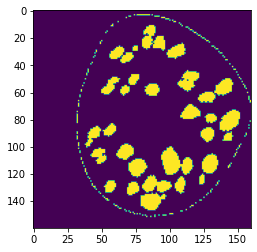

In [16]:
#image = cv2.imread("../data/train/masks_old/vago DX  - 27.06.18 - HH - vetrino 1 - centrale - campione 0010.jpg")
#image = cv2.imread("../data/mask/00005.mask.tif")
image = cv2.imread("../data/mask/augmented_mask_1_627966.jpg")
print(image.shape)
(thresh, image) = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
print(image.shape)

label_img = label(image)
regions = regionprops(label_img)
plt.imshow(image)

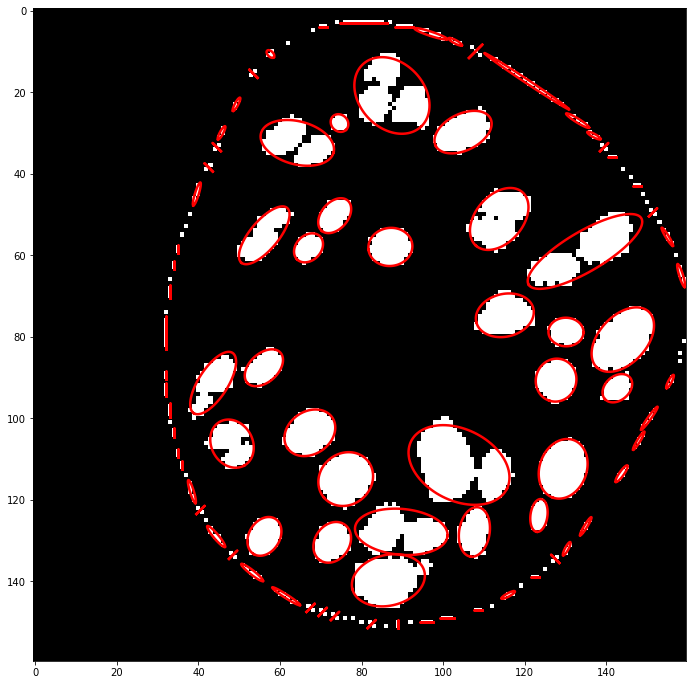

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = math.pi /2 - props.orientation
    moments = props.moments_central
    theta = np.linspace(0, 2*math.pi, 100)
    x = x0 + 0.5 * props.major_axis_length * math.cos(orientation) * np.cos(theta) - 0.5 * props.minor_axis_length * math.sin(orientation) * np.sin(theta) 
    y = y0 + 0.5 * props.major_axis_length * math.sin(orientation) * np.cos(theta) + 0.5 * props.minor_axis_length * math.cos(orientation) * np.sin(theta)
    ax.plot(x, y, '-r', linewidth=2.5)

plt.show()